<a href="https://colab.research.google.com/github/aravindH6/yanamalaaravind-icp-KDM-spring-2021/blob/main/ICP11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this ICP we will build 2 feed forward network.

>Auto Encoder

>CNN

>Data Set

>>The MNIST database of handwritten digits. Training set of 60,000 examples, and a test set of 10,000 examples


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Auto Encoders:

>>Data compression is a big topic that’s used in computer vision, computer networks, computer architecture, and many other fields.The point of data compression is to convert our input into a smaller representation that we recreate, to a degree of quality. This smaller representation is what would be passed around, and, when anyone needed the original, they would reconstruct it from the smaller representation.Autoencoders are unsupervised neural networks that use machine learning to do this compression 


In [22]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.datasets import cifar10
 
import numpy as np
import matplotlib.pyplot as plt



Load  cifar100 handwritten digits dataset.

There is no need to load labels because autoencoders are unsupervised.

Rescale our images from 0 – 255 to 0 – 1 and flatten them out.


In [26]:
#Notice that we’re not loading any of the labels because autoencoders are unsupervised
(X_train, _), (X_test, _) = cifar10.load_data()
# rescale our images from 0 – 255 to 0 – 1 and flatten them out.

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

In [27]:
X_train.shape

(50000, 3072)

In [28]:
X_test.shape

(10000, 3072)

In [29]:
INPUT_SIZE = 3072
ENCODING_SIZE = 64

Create autoencoder
	
Use ReLU  activation functions 

create constants for our input size and our encoding size. 

reduce our input from 784 -> 512 -> 256 -> 128 -> 64, encoder path

then expand it back up 64 -> 128 -> 256 -> 512 -> 784, decoder path


In [30]:
#reduce our input from 784 -> 512 -> 256 -> 128 -> 64 (encoder path), then expand it back up 64 -> 128 -> 256 -> 512 -> 784(decoder path).
# Also notice the relu activation function
input_img = Input(shape=(INPUT_SIZE,))
encoded = Dense(1024, activation='relu')(input_img)
encoded = Dense(512, activation='relu')(encoded)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(ENCODING_SIZE, activation='relu')(encoded)

In [31]:
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(512, activation='relu')(decoded)
decoded = Dense(1024, activation='relu')(decoded)
decoded = Dense(INPUT_SIZE, activation='relu')(decoded)


In [32]:
autoencoder = Model(input_img, decoded)

Training the model and then making the prediction 

Build and train the model.

Use the ADAM optimizer and mean squared error loss (the Euclidean distance/loss) between the input and reconstruction

encode and decode the test set to see how well model is performing



In [33]:
#using ADAM optimizer and mean squared error loss (the Euclidean distance/loss) between the input and reconstruction
autoencoder.compile(optimizer='adam', loss='mean_squared_error',)
autoencoder.fit(X_train, X_train, epochs=70, batch_size=256, shuffle=True, validation_split=0.2)

Epoch 1/70
157/157 [==============================] - 2s 10ms/step - loss: 0.1481 - val_loss: 0.0619
Epoch 2/70
157/157 [==============================] - 1s 9ms/step - loss: 0.0574 - val_loss: 0.0448
Epoch 3/70
157/157 [==============================] - 1s 9ms/step - loss: 0.0432 - val_loss: 0.0361
Epoch 4/70
157/157 [==============================] - 1s 9ms/step - loss: 0.0354 - val_loss: 0.0316
Epoch 5/70
157/157 [==============================] - 1s 9ms/step - loss: 0.0310 - val_loss: 0.0264
Epoch 6/70
157/157 [==============================] - 1s 9ms/step - loss: 0.0266 - val_loss: 0.0259
Epoch 7/70
157/157 [==============================] - 1s 9ms/step - loss: 0.0259 - val_loss: 0.0256
Epoch 8/70
157/157 [==============================] - 1s 9ms/step - loss: 0.0256 - val_loss: 0.0236
Epoch 9/70
157/157 [==============================] - 1s 9ms/step - loss: 0.0236 - val_loss: 0.0223
Epoch 10/70
157/157 [==============================] - 1s 9ms/step - loss: 0.0225 - val_loss: 0.022

In [34]:
#After our autoencoder has trained, we can try to encode and decode the test set to see how well our autoencoder can compress
decoded_imgs = autoencoder.predict(X_test)

Visvualize the results 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


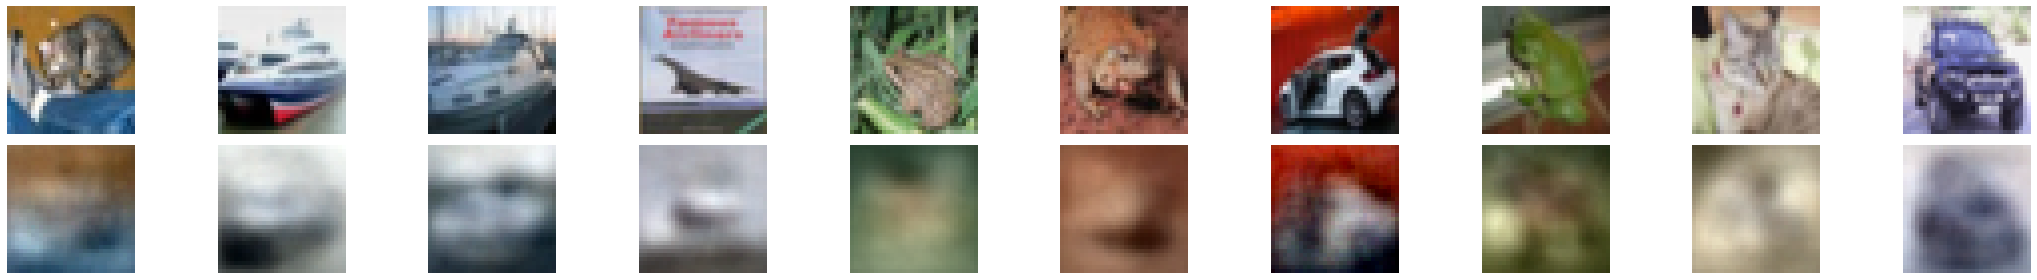

In [36]:

plt.figure(figsize=(30, 4))
for i in range(10):
    # original
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_test[i].reshape(32, 32, 3))
    plt.gray()
    plt.axis('off')
 
    # reconstruction
    plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    plt.axis('off')
 
plt.tight_layout()
plt.show()

CNN 

The Problem: MNIST digit classification
	
We’re going to tackle a classic introductory Computer Vision problem: MNIST handwritten digit classification. It’s simple: given an image, classify it as a digit
	
Each image in the MNIST dataset is 28x28 and contains a centered, grayscale digit. Our CNN will take an image and output one of 10 possible classes (one for each digit)

First of all,  import all necessary packages



In [37]:
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import to_categorical

In [38]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

Before we begin, we’ll normalize the image pixel values from [0, 255] to [-0.5, 0.5]
	 
This will  make our network easier to train (using smaller, centered values usually leads to better results). 

We’ll also reshape each image from (28, 28) to (28, 28, 1) because Keras requires the third dimension. (1 stands for color scheme, which is grey scale in this case). 



In [39]:
# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

In [40]:
print(train_images.shape);

(50000, 32, 32, 3)


In [41]:
# Reshape the images.
#train_images = np.expand_dims(train_images, axis=3)
#test_images = np.expand_dims(test_images, axis=3)

Keras model is either built using the Sequential class, which represents a linear stack of layers, or the functional Model class, which is more customizable. 

We’ll be using the simpler Sequential model, since our CNN will be a linear stack of layers.

num_filters, filter_size, and pool_size are self-explanatory variables that set the hyperparameters for our CNN.

The first layer in any Sequential model must specify the input_shape, so we do so on Conv2D. 

Once this input shape is specified, Keras will automatically infer the shapes of inputs for later layers.
	
The output Softmax layer has 10 nodes, one for each class




In [42]:

num_filters = 12
filter_size = 5
pool_size = 2

In [43]:
# Build the model.
model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(32, 32, 3)),
  MaxPooling2D(pool_size=pool_size),
  Flatten(),
  Dense(10, activation='softmax'),
])

Before we can begin training, we need to configure the training process. We decide 3 key factors during the compilation step:
	
The optimizer. We’ll stick with a pretty good default: the Adam gradient-based optimizer. Keras has many other optimizers you can look into as well.

The loss function. Since we’re using a Softmax output layer, we’ll use the Cross-Entropy loss. Keras distinguishes between binary_crossentropy (2 classes) and categorical_crossentropy (>2 classes), so we’ll use the latter. 

A list of metrics. Since this is a classification problem, we’ll just have Keras report on the accuracy metric.



In [44]:
# Compile the model.
model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

Training a model in Keras literally consists only of calling fit() and specifying some parameters. There are a lot of possible parameters, but we’ll only supply these:

The training data (images and labels), commonly known as X and Y, respectively.

The number of epochs (iterations over the entire dataset) to train for.

The validation data (or test data), which is used during training to periodically measure the network’s performance against data it hasn’t seen before.

There’s one thing we have to be careful about:

Keras expects the training targets to be 10-dimensional vectors, since there are 10 nodes in our Softmax output layer. Right now, our train_labels and test_labels arrays contain single integers representing the class for each image

Conveniently, Keras has a utility method that fixes this exact issue:
to_categorical: It turns our array of class integers into an array of one-hot vectors instead. For example, 2 would become [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] (it’s zero-indexed)





In [45]:
# Train the model.
model.fit(
  train_images,
  to_categorical(train_labels),
  epochs=30,
  validation_data=(test_images, to_categorical(test_labels)),
)

Epoch 1/30
1563/1563 [==============================] - 6s 3ms/step - loss: 1.7435 - accuracy: 0.3907 - val_loss: 1.4208 - val_accuracy: 0.5067
Epoch 2/30
1563/1563 [==============================] - 5s 3ms/step - loss: 1.3844 - accuracy: 0.5177 - val_loss: 1.3351 - val_accuracy: 0.5400
Epoch 3/30
1563/1563 [==============================] - 5s 3ms/step - loss: 1.2683 - accuracy: 0.5657 - val_loss: 1.2665 - val_accuracy: 0.5598
Epoch 4/30
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1897 - accuracy: 0.5905 - val_loss: 1.2310 - val_accuracy: 0.5815
Epoch 5/30
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1457 - accuracy: 0.6058 - val_loss: 1.1787 - val_accuracy: 0.5971
Epoch 6/30
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1015 - accuracy: 0.6235 - val_loss: 1.2037 - val_accuracy: 0.5892
Epoch 7/30
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0655 - accuracy: 0.6363 - val_loss: 1.1690 - val_accuracy:

In [46]:
# Predict on the first 20 test images.
predictions = model.predict(test_images[:20])

In [47]:
# Print our model's predictions.
print("These are the model predictions :")
print(np.argmax(predictions, axis=1)) 
print("\n")

These are the model predictions :
[8 8 8 8 6 6 1 6 3 1 0 9 3 7 9 8 5 5 8 6]




In [48]:
# Check our predictions against the ground truths.
print("These are the corresponding labels :")
print(test_labels[:20]) 

These are the corresponding labels :
[[3]
 [8]
 [8]
 [0]
 [6]
 [6]
 [1]
 [6]
 [3]
 [1]
 [0]
 [9]
 [5]
 [7]
 [9]
 [8]
 [5]
 [7]
 [8]
 [6]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

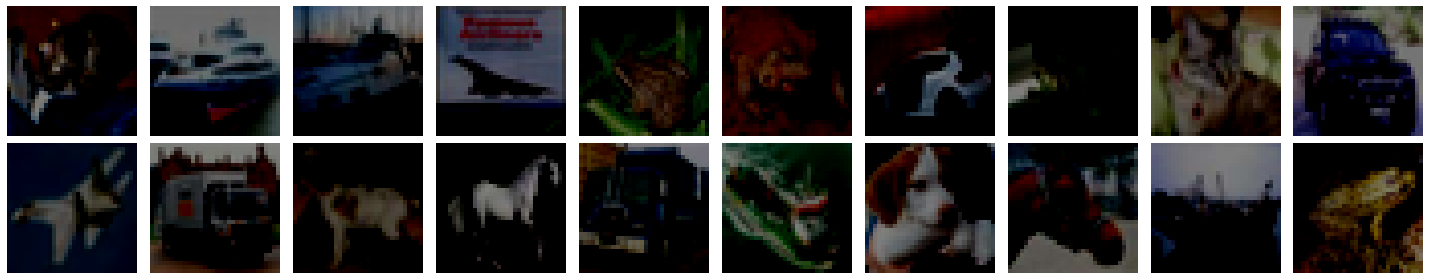

In [49]:

plt.figure(figsize=(20, 4))
for i in range(20):
    # original
    plt.subplot(2, 10, i + 1)
    plt.imshow(test_images[i])
    plt.gray()
    plt.axis('off')
 
 
plt.tight_layout()
plt.show()